# Real or Not? NLP with Disaster Tweets

Submissions are evaluated using F1 between the predicted and expected answers.

F1 is calculated as follows:<br>
F1=2∗precision∗recallprecision+recall<br>

where:

precision=TPTP+FP
recall=TPTP+FN
and:

True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

Submission File
For each ID in the test set, you must predict 1 if the tweet is describing a real disaster, and 0 otherwise. The file should contain a header and have the following format:

id,target
0,0 <br>
2,0 <br>
3,1 <br>
9,0 <br>
11,0 <br>

In [1]:
import pandas as pd
import sklearn
import sklearn.feature_extraction
import sklearn.neighbors
from sklearn.model_selection import train_test_split
import spacy
import numpy as np

In [2]:
# nlp_train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
# nlp_test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

nlp_train_df = pd.read_csv('C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/train.csv')
nlp_test_df =  pd.read_csv('C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/test.csv')

In [3]:
nlp_test_df[nlp_test_df["keyword"].notnull()]

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...
...,...,...,...,...
3247,10806,wrecked,Seattle Washington,RT CNBC '3 words from Disney CEO Bob Iger wrec...
3248,10807,wrecked,Acey mountain islanddåÇTorontoåÈ,Smackdown tyme this should put me in a good mo...
3249,10816,wrecked,los angeles,@thrillhho jsyk I haven't stopped thinking abt...
3250,10820,wrecked,"Brussels, Belgium",@stighefootball Begovic has been garbage. He g...


## Tokenisation, creating BoW

In [4]:
nlp_traintest_df = nlp_train_df.append(nlp_test_df)

In [5]:
nlp_traintest_df[len(nlp_train_df.index)-2:].head()

,id,keyword,location,text,target
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1.0
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1.0
0,0,NaN,NaN,Just happened a terrible car crash,NaN
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN


#### Add keyword

In [8]:
nlp_traintest_df["text_kword"] = nlp_traintest_df["text"]

nlp_traintest_df.loc[nlp_traintest_df["keyword"].notnull(), "text_kword"] = nlp_traintest_df[nlp_traintest_df["keyword"].notnull()]["text"] + ", " + nlp_traintest_df[nlp_traintest_df["keyword"].notnull()]["keyword"]
#nlp_traintest_df[nlp_traintest_df["keyword"].isnull()]["text_kword"] = nlp_traintest_df[nlp_traintest_df["keyword"].isnull()]["text"]

In [16]:
nlp_traintest_df[nlp_traintest_df["keyword"].notnull()].iloc[0, 5]

'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C, ablaze'

### Train Test split & K Fold Cross Vaildation set up

In [17]:
vectoriser = sklearn.feature_extraction.text.CountVectorizer(
    stop_words="english",
    vocabulary=None)
tokens = vectoriser.fit_transform(nlp_traintest_df.text_kword.values)

In [18]:
counts = tokens[:len(nlp_train_df.index)]
targets=nlp_train_df.target.values
test_tokens = tokens[len(nlp_train_df.index):]

In [19]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(counts, targets, test_size=0.2, random_state=1, stratify=targets)

## K Nearest Neighbours

In [20]:
# Create KNN classifier
kneighbours_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')

# Fit the classifier to the data
kneighbours_classifier.fit(X_train, y_train);

In [21]:
training_pred = kneighbours_classifier.predict(X_test)

In [22]:
kneighbours_classifier.score(X_test, y_test)

0.7137229152987524

#### K Nearest Neighbours using K fold Cross Validation

In [23]:
from sklearn.model_selection import cross_val_score

#create a new KNN model
kneighbours_classifier_cv = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')

#train model with cv of 5
cv_scores = cross_val_score(kneighbours_classifier_cv, counts, targets, cv=5)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.57715036 0.53841103 0.52527905 0.58344284 0.57161629]
cv_scores mean:0.5591799158414602


#### Find n_neighbours using grid search

In [24]:
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = sklearn.neighbors.KNeighborsClassifier(weights='distance')

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25),
             'algorithm': ['auto'],
             'weights': ['uniform', 'distance']}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

#fit model to data
knn_gscv.fit(counts, targets)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'algorithm': 'auto', 'n_neighbors': 22, 'weights': 'uniform'}

In [26]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.57152311081162

In [29]:
kneighbours_f1 = sklearn.metrics.f1_score(y_test, training_pred)
print(kneighbours_f1)

0.5902255639097744


## Multinomial Naive Bayes

In [32]:
from sklearn import naive_bayes

In [ ]:
#naive_bayes.LabelBinarizer

In [34]:
mnb_classifier = naive_bayes.MultinomialNB()
mnb_classifier.fit(counts, targets)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### K fold Cross Validation

In [35]:
from sklearn.model_selection import cross_val_score

#create a new MNB model
mnb_classifier_cv = naive_bayes.MultinomialNB()

#train model with cv of 5
cv_scores = cross_val_score(mnb_classifier_cv, counts, targets, cv=5)

#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.6684176  0.54760341 0.62245568 0.65703022 0.66162943]
cv_scores mean:0.6314272698172482


In [38]:
cv_scores

array([0.6684176 , 0.54760341, 0.62245568, 0.65703022, 0.66162943])

In [46]:
mnb_training_preds = mnb_classifier.predict(counts)

In [47]:
mnb_f1 = sklearn.metrics.f1_score(targets, mnb_training_preds)
print(mnb_f1)

0.8820960698689957


## Gaussian Naive Bayes

In [43]:
gnb_classifier = naive_bayes.GaussianNB()
gnb_classifier.fit(counts.toarray(), targets)

GaussianNB(priors=None, var_smoothing=1e-09)

#### K fold Cross Validation

In [44]:
#create a new MNB model
gnb_classifier_cv = naive_bayes.GaussianNB()

#train model with cv of 5
gnb_cv_scores = cross_val_score(gnb_classifier_cv, counts.toarray(), targets, cv=5)

#print each cv score (accuracy) and average them
print(gnb_cv_scores)
print('gnb cv_scores mean:{}'.format(np.mean(gnb_cv_scores)))

[0.57124097 0.4983585  0.50952068 0.56833114 0.54599212]
gnb cv_scores mean:0.5386886832907248


## Artificial Neural Networks

In [45]:
# Load the SpaCy model
# Create an empty model
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)



In [46]:
# Add labels to text classifier
textcat.add_label("0")
textcat.add_label("1")


1

In [47]:
# train_data = list(zip(nlp_train_df.text, nlp_train_df.target))
train_text=nlp_train_df.text.values
train_labels= nlp_train_df.target.astype(str).values

In [48]:
print(train_labels[10:20])
len(train_labels)

['1' '1' '1' '1' '1' '0' '0' '0' '0' '0']


7613

In [49]:
train_cats = [{'cats': {'0': label == '0',
                          '1': label == '1'}} 
                for label in train_labels]

In [50]:
train_data = list(zip(train_text, train_cats))
train_data[:3]

[('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
  {'cats': {'0': False, '1': True}}),
 ('Forest fire near La Ronge Sask. Canada', {'cats': {'0': False, '1': True}}),
 ("All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
  {'cats': {'0': False, '1': True}})]

In [51]:
from spacy.util import minibatch

#spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Create the batch generator with batch size = 8
batches = minibatch(train_data, size=8)

for batch in batches:
    # Each batch is a list of (text, label) but we need to
    # send separate lists for texts and labels to update().
    # This is a quick way to split a list of tuples into lists
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)

In [52]:
import random

random.seed(1)
#spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=8)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)

{'textcat': 4.218708319298457}
{'textcat': 7.017426509773941}
{'textcat': 8.9887739869082}
{'textcat': 10.454843768966384}
{'textcat': 11.57777149625963}
{'textcat': 12.466047293995416}
{'textcat': 13.190818991384276}
{'textcat': 13.787889550772888}
{'textcat': 14.284105327213638}
{'textcat': 14.706968871316121}


In [56]:
texts = train_text
docs = [nlp.tokenizer(text) for text in texts]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)

[[2.2221806e-02 9.7777814e-01]
 [1.1242663e-02 9.8875731e-01]
 [2.7139140e-02 9.7286093e-01]
 ...
 [4.2553241e-03 9.9574465e-01]
 [2.5352971e-03 9.9746466e-01]
 [5.5184391e-05 9.9994481e-01]]


In [57]:
predicted_labels = scores.argmax(axis=1)
print([textcat.labels[label] for label in predicted_labels])

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0', '0',

In [58]:
import sklearn.metrics

In [59]:
f1 = sklearn.metrics.f1_score(nlp_train_df.target.values, predicted_labels)
print(f1)

0.9900107576456124


In [60]:
texts = nlp_test_df.text.values
docs = [nlp.tokenizer(text) for text in texts]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

predicted_labels = scores.argmax(axis=1)
print([textcat.labels[label] for label in predicted_labels])

['1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1',

In [66]:
np.savetxt("C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/GaborJenei_Submission_v3.csv",
                   predicted_labels.astype(int), delimiter="\n")

In [67]:
ann_out_df = nlp_test_df
ann_out_df["target"] = predicted_labels
ann_out_df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [68]:
ann_out_df.to_csv("C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/GaborJenei_Submission_v3.csv",
                 columns=['id','target'], index=False)

## Three Methods Voting

In [72]:
combined_prediction_df = nlp_test_df
combined_prediction_df["KNN Pred"] = kneighbours_classifier.predict(test_tokens)
combined_prediction_df["MND Pred"] = mnb_classifier.predict(test_tokens)
combined_prediction_df["ANN Pred"] = predicted_labels

In [74]:
combined_prediction_df["avg score"] = combined_prediction_df[["KNN Pred", "MND Pred", "ANN Pred"]].mean(axis=1)

In [86]:
combined_prediction_df["Final Pred"] = combined_prediction_df["avg score"].round(0).astype('int')

In [87]:
combined_prediction_df.to_csv("C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/GaborJenei_Submission_v4.csv",
                 columns=['id','Final Pred'], index=False)

## Prepare submission file

In [16]:
kneighbours_classifier.predict(test_tokens)

nlp_test_df['target'] = kneighbours_classifier.predict(test_tokens)

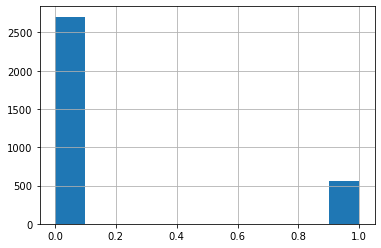

In [21]:
nlp_test_df.target.hist();

In [18]:
nlp_test_df.to_csv('C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/GaborJenei_Submission_v2.csv',
                   columns=['id','target'], index=False)

In [56]:
nlp_test_df['target'] = predicted_labels

In [57]:
nlp_test_df.to_csv('C:/Projects/0_Learning/1_Kaggle/nlp-getting-started/GaborJenei_Submission_v1.csv',
                   columns=['id','target'], index=False)